In [2]:
from pathlib import Path
import subprocess

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

label = pd.read_csv("/1pha/biobank-h5/h5/ukb_age_label.csv")
_label = label.fname.apply(lambda s: s.split("_")[0])

### Patient Pick-up Pipeline

1. Remove Duplicate sessions
2. Exclude Hard-coded test non-registrated sessions

Save 1 & 2 results somewhere ...

#### 1. Remove Duplicate Sessions

In [3]:
_dups_bool = _label.duplicated(keep=False)
label_nodups = label[~_dups_bool]

Duplicated sessions EDA

In [4]:
label_dups = label[_dups_bool]
label_dups.loc[:, "pid"] = label_dups.fname.apply(lambda s: s.split("_")[0])
label_dups = label_dups.sort_values(by=["pid", "age"])

/tmp/ipykernel_7060/3920320138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_dups.loc[:, "pid"] = label_dups.fname.apply(lambda s: s.split("_")[0])


In [5]:
def sub(ser):
    return ser.iloc[-1] - ser.iloc[0]

dist = label_dups.groupby("pid").agg({"age": ["mean", sub]})

In [6]:
dist.age["sub"].value_counts().sort_index()

sub
1.0       7
2.0    2286
3.0     838
4.0      14
5.0      25
6.0      20
7.0       8
Name: count, dtype: int64

<Axes: >

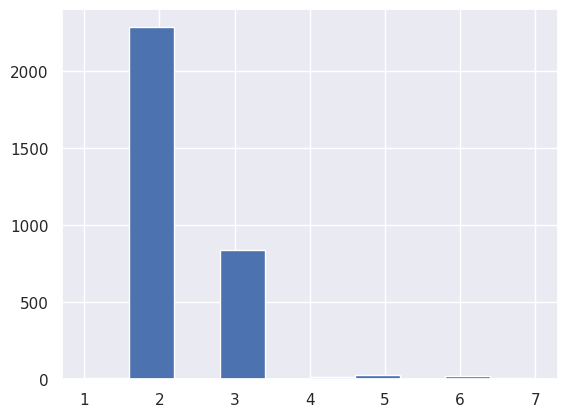

In [7]:
dist.age["sub"].hist()

### 2. Remove Non-reg hold-out test

In [8]:
with open("/1pha/nonreg-test.txt", mode="r") as f:
    nonreg = f.readlines()
nonreg = [s.rstrip("\n") for s in nonreg]
nonreg = [s.split("-")[0] for s in nonreg]

_label_nodups = label_nodups.fname.apply(lambda s: s.split("_")[0])
_nonreg_label = _label_nodups.isin(nonreg)

In [9]:
label_nodups[_nonreg_label]

,fname,age
0,1000126_20252_2_0,66.0
1,1000190_20252_2_0,54.0
2,1000239_20252_2_0,67.0
3,1000497_20252_2_0,74.0
6,1000641_20252_2_0,53.0
...,...,...
3795,1403381_20252_2_0,74.0
3798,1404267_20252_2_0,66.0
3799,1404323_20252_2_0,66.0
3801,1404420_20252_2_0,55.0


<Axes: >

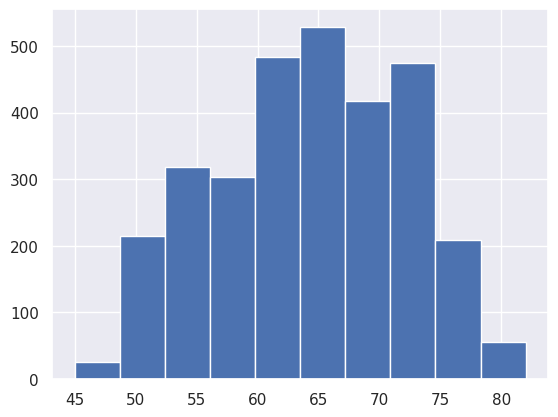

In [10]:
label_nodups[_nonreg_label].age.hist()

In [11]:
sum(_nonreg_label), len(nonreg)

(3029, 3262)

### 3. Sample out VBMs

In [10]:
seed = 42
vbm_candidates = label_nodups[_nonreg_label]

In [11]:
VBM_PATH = Path("./vbm/")
VBM_PATH.mkdir(exist_ok=True)

(VBM_PATH / "meta").mkdir(exist_ok=True)

In [12]:
old_vbm = vbm_candidates[vbm_candidates.age > 76]
old_vbm

,fname,age
62,1006854_20252_2_0,79.0
143,1015844_20252_2_0,78.0
163,1018063_20252_2_0,80.0
165,1018312_20252_2_0,80.0
167,1018562_20252_2_0,79.0
...,...,...
3730,1396568_20252_2_0,79.0
3731,1396577_20252_2_0,77.0
3745,1397981_20252_2_0,80.0
3791,1402836_20252_2_0,78.0


In [13]:
young_vbm = vbm_candidates[vbm_candidates.age < 55]
young_vbm

,fname,age
1,1000190_20252_2_0,54.0
6,1000641_20252_2_0,53.0
9,1000715_20252_2_0,50.0
14,1001456_20252_2_0,51.0
19,1002143_20252_2_0,52.0
...,...,...
3752,1398893_20252_2_0,54.0
3755,1399161_20252_2_0,54.0
3764,1400285_20252_2_0,49.0
3770,1400900_20252_2_0,53.0


In [14]:
n_vbm = min(100, min(len(old_vbm), len(young_vbm)))
print(n_vbm)

100


In [15]:
old = old_vbm.sample(n=n_vbm, random_state=seed)
old.age.to_csv(VBM_PATH / "meta" / "old_age.txt", index=False)
old.to_csv(VBM_PATH / "meta" / "old.txt", index=False)

young = young_vbm.sample(n=n_vbm, random_state=seed)
young.age.to_csv(VBM_PATH / "meta" / "young_age.txt", index=False)
young.to_csv(VBM_PATH / "meta" / "young.txt", index=False)

In [16]:
NONREG_PATH = Path("/1pha/biobank_brainmask")

In [17]:
def fix_fname(s: str):
    return NONREG_PATH / f"{s.split('_')[0]}-biobank-brainmask.nii"
old_fnames = old.fname.apply(fix_fname)
young_fnames = young.fname.apply(fix_fname)

In [18]:
YOUNG_PATH = VBM_PATH / "young"
YOUNG_PATH.mkdir(exist_ok=True)
for fname in tqdm(young_fnames.values):
    _path = YOUNG_PATH / fname.stem
    _path.mkdir(exist_ok=True)
    subprocess.run(args=["cp", fname, YOUNG_PATH / fname.stem])

In [20]:
OLD_PATH = VBM_PATH / "old"
OLD_PATH.mkdir(exist_ok=True)
for fname in tqdm(old_fnames.values):
    _path = OLD_PATH / fname.stem
    _path.mkdir(exist_ok=True)
    subprocess.run(args=["cp", fname, OLD_PATH / fname.stem])

100%|██████████| 100/100 [00:05<00:00, 17.03it/s]


In [23]:
# sanity check
!ls $OLD_PATH | wc -l
!ls $YOUNG_PATH | wc -l

100
100


### 4. Train/Test dataset

In [15]:
files = sorted(Path("/1pha/biobank-h5/h5").rglob("*.h5"))

In [44]:
label_nodups[~_nonreg_label].to_csv("/1pha/biobank-h5/h5/ukb_trainval_age.csv", index=False)
label_nodups[_nonreg_label].to_csv("/1pha/biobank-h5/h5/ukb_test_age.csv", index=False)

In [51]:
# trainval_pid = set(label_nodups[~_nonreg_label].fname)
trainval_pid = set(pd.read_csv("/1pha/biobank-h5/h5/ukb_trainval_age.csv").fname.unique())
trainval = list(filter(lambda f: f.stem in trainval_pid, files))

In [52]:
len(trainval)

36675